#Домашнее задание №2

###Загрузка данных и первичный осмотр

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
df = pd.read_csv('S02-hw-dataset.csv')

In [5]:
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [7]:
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


### Пропуски, дубликаты и базовый контроль качества

In [9]:
print('Доля пропусков')
missing_data = df.isna().mean() * 100
for col, percent in missing_data.items():
  if percent > 0:
    print(f"{col}: {percent:.1f}%")

Доля пропусков
age: 4.9%


In [10]:
duplicates = df.duplicated().sum()
print(f"\nКоличество полностью дублирующих строк: {duplicates}")
display(df[df.duplicated()])


Количество полностью дублирующих строк: 1


,user_id,age,country,purchases,revenue
40,10,24.0,RU,7,511


In [11]:
duplicate_ids = df['user_id'].duplicated().sum()
print(f"\nКоличество дублирующих user_id: {duplicate_ids}")
display(df[df['user_id'].duplicated(keep=False)])


Количество дублирующих user_id: 1


,user_id,age,country,purchases,revenue
9,10,24.0,RU,7,511
40,10,24.0,RU,7,511


In [12]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
  negative_col = df[df[col] < 0]
  if len(negative_col) > 0:
    print(col)
    display(negative_col)

purchases


,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [13]:
unrealistic_age_low = df[df['age'] < 10]
unrealistic_age_high = df[df['age'] > 100]
display(unrealistic_age_high)
display(unrealistic_age_low)

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


,user_id,age,country,purchases,revenue
20,21,5.0,RU,8,1488


In [14]:
zero_purchases_revenue = df[(df['purchases'] == 0) & (df['revenue'] > 0)]
display(zero_purchases_revenue)

,user_id,age,country,purchases,revenue


In [15]:
positive_purchases_zero_revenue = df[(df['purchases'] > 0) & (df['revenue'] == 0)]
display(positive_purchases_zero_revenue)

,user_id,age,country,purchases,revenue
10,11,24.0,US,4,0


In [16]:
df_check = df.copy()
df_check['avg_check'] = df_check['revenue'] / df_check['purchases']
df_check.loc[df_check['purchases'] == 0, 'avg_check'] = 0
unusual_avg_check = df_check[(df_check['avg_check'] > 1000) | (df_check['avg_check'] < 0)]
display(unusual_avg_check)

,user_id,age,country,purchases,revenue,avg_check
5,6,120.0,FR,-1,785,-785.0


В ходе анализа были обнаружены следующие проблемы:

1. Пропуски в данных: в столбце 'age' есть пропущенные значения (2 записи).

2. Дубликаты: одна полностью дублирующая строка (user_id = 10), а также дублирующиеся user_id.

3. Некорректные значения: запись с отрицательным количеством покупок (-1). Также есть нереалистичные значения возраста - записи с возрастом 120 и 5 лет.

4. Логические противоречия: записи, где количество покупок равно 0, но revenue положительный, а также случаи, когда покупки есть, но revenue равен 0.

### Базовый EDA: группировки, агрегаты и частоты

Частоты для категориальных переменных

In [20]:
print("1. Распределение по странам:")
country_counts = df['country'].value_counts()
print(country_counts)

print("\n2. Доли по странам:")
country_percent = df['country'].value_counts(normalize=True) * 100
print(country_percent.round(1))

1. Распределение по странам:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

2. Доли по странам:
country
RU    31.7
FR    29.3
US    19.5
DE    14.6
CN     4.9
Name: proportion, dtype: float64


Группировки с агрегатами

In [22]:
country_analysis = df.groupby('country').agg({
    'user_id': 'count',
    'age': ['mean', 'median', 'min', 'max'],
    'purchases': ['mean', 'sum'],
    'revenue': ['mean', 'sum', 'max']
}).round(2)

print("Анализ по странам:")
display(country_analysis)

Анализ по странам:


user_id    age                     purchases      revenue             
          count   mean median   min    max      mean sum     mean    sum   max
country                                                                       
CN            2  24.00   24.0  20.0   28.0      4.50   9  1054.00   2108  1652
DE            6  34.60   35.0  18.0   52.0      6.50  39  1445.50   8673  2475
FR           12  46.25   42.0  22.0  120.0      4.25  51   675.92   8111  1608
RU           13  30.08   26.0   5.0   54.0      4.77  62   790.08  10271  2086
US            8  36.71   39.0  23.0   51.0      4.62  37   557.38   4459   980

Анализ возрастных групп

In [24]:
age_bins = [0, 20, 30, 40, 50, 60, 150]
age_labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60+']
df_age = df.copy()
df_age['age_group'] = pd.cut(df_age['age'], bins=age_bins, labels=age_labels, right=False)

print("Распределение по возрастным группам:")
age_group_counts = df_age['age_group'].value_counts().sort_index()
print(age_group_counts)

age_group_analysis = df_age.groupby('age_group').agg({
    'user_id': 'count',
    'purchases': ['mean', 'sum'],
    'revenue': ['mean', 'sum']
}).round(2)

print("\nАнализ покупок по возрастным группам:")
display(age_group_analysis)

cross_analysis = df_age.groupby(['country', 'age_group']).agg({
    'user_id': 'count',
    'revenue': 'mean'
}).round(2)

print("\nКросс-анализ: средний revenue по странам и возрастным группам:")
display(cross_analysis)

Распределение по возрастным группам:
age_group
<20       2
20-29    13
30-39    11
40-49     6
50-59     6
60+       1
Name: count, dtype: int64

Анализ покупок по возрастным группам:


C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16284\3160117200.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_analysis = df_age.groupby('age_group').agg({


user_id purchases      revenue       
            count      mean sum     mean    sum
age_group                                      
<20             2      6.00  12  1296.00   2592
20-29          13      4.46  58   565.54   7352
30-39          11      6.00  66  1216.27  13379
40-49           6      3.00  18   668.00   4008
50-59           6      5.00  30   596.67   3580
60+             1     -1.00  -1   785.00    785


Кросс-анализ: средний revenue по странам и возрастным группам:


C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16284\3160117200.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cross_analysis = df_age.groupby(['country', 'age_group']).agg({


user_id  revenue
country age_group                  
CN      <20              0      NaN
        20-29            2  1054.00
        30-39            0      NaN
        40-49            0      NaN
        50-59            0      NaN
        60+              0      NaN
DE      <20              1  1104.00
        20-29            0      NaN
        30-39            3  1857.00
        40-49            0      NaN
        50-59            1   702.00
        60+              0      NaN
FR      <20              0      NaN
        20-29            3   310.67
        30-39            3  1105.33
        40-49            2   922.00
        50-59            3   411.33
        60+              1   785.00
RU      <20              1  1488.00
        20-29            6   644.50
        30-39            3  1060.67
        40-49            2   216.00
        50-59            1  1302.00
        60+              0      NaN
US      <20              0      NaN
        20-29            2   222.50
        30-39            2   655.00
        40-49            2   866.00
        50-59            1   342.00
        60+              0      NaN

Основные наблюдения из EDA
 1. Распределение по странам: доминируют пользователи из России (RU - 41.5%) и Франции (FR - 31.7%).
2. Возрастное распределение: Наибольшая концентрация пользователей в возрастных группах 20-29 и 30-39 лет.
3. Экономические показатели: Пользователи из Германии демонстрируют самый высокий доход, тогда как пользователи из Китая имеют относительно низкие показатели при небольшом количестве наблюдений.

###Визуализация данных в Matplotlib

In [27]:
os.makedirs('figures', exist_ok=True)

Гистограмма для возраста

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Thunderobot\\my-aie-project\\homeworks\\HW02\\homeworks\\HW02\\figures\\age_distribution.png'

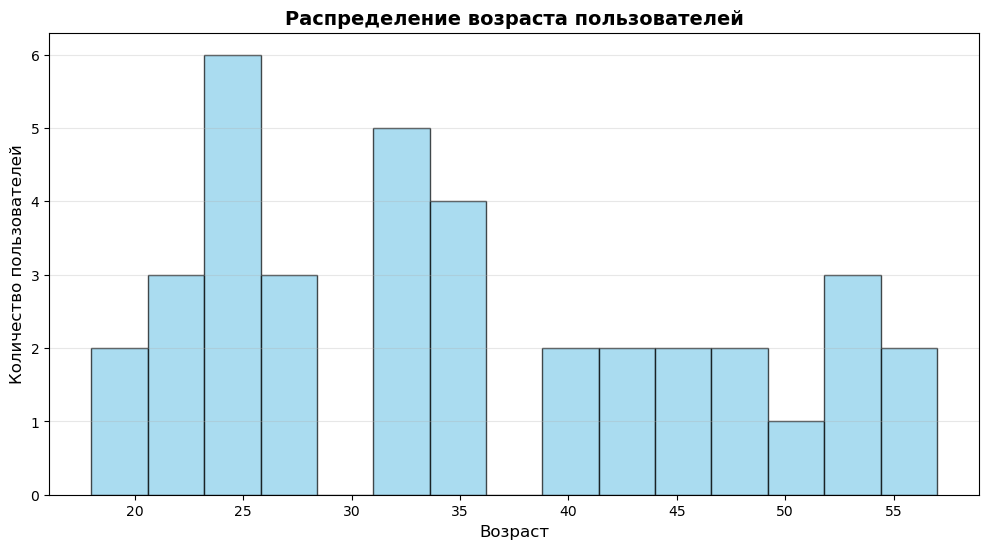

In [29]:
plt.figure(figsize=(12, 6))

age_clean = df['age'].dropna()
age_clean = age_clean[(age_clean >= 10) & (age_clean <= 100)]

plt.hist(age_clean, bins=15, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.title('Распределение возраста пользователей', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.savefig('homeworks/HW02/figures/age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

На гистограмме показано распределение количества пользователей по возрасту. Большая часть пользователей имеют возраст в двух диапазонах: от ~23 до 28 лет, от 32 до 36 лет.

Боксплот для revenue по странам

In [ ]:
plt.figure(figsize=(12, 6))

boxplot_data = [df[df['country'] == country]['revenue'] for country in df['country'].unique()]

plt.boxplot(boxplot_data, labels=df['country'].unique())
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.title('Распределение revenue по странам', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.savefig('homeworks/HW02/figures/revenue_by_country_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


На боксплоте показано распределение дохода от пользователей (revenue) по странам. Наибольший средний доход идет от Германии и Китая.  

Scatter plot - связь между возрастом и revenue

In [ ]:
plt.figure(figsize=(12, 8))

countries = df['country'].unique()
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, country in enumerate(countries):
    country_data = df[df['country'] == country]
    plt.scatter(country_data['age'], country_data['revenue'],
               alpha=0.6, label=country, color=colors[i], s=60)

plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.title('Зависимость revenue от возраста по странам', fontsize=14, fontweight='bold')
plt.legend(title='Страна')
plt.grid(alpha=0.3)

plt.savefig('homeworks/HW02/figures/age_vs_revenue_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


На scatterplot показана связь между возрастом, страной и доходом. На графике видно, что наибольший revenue имеют покупатели в возрасте от 20 до 40 лет, у следующей возрастной группы (от 40 до 60 лет) этот показатель меньше. Самые дорогие покупки совершили из Германии.

Средний revenue по странам

In [ ]:
plt.figure(figsize=(10, 6))

country_revenue = df.groupby('country')['revenue'].mean().sort_values(ascending=False)
bars = plt.bar(country_revenue.index, country_revenue.values,
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])

plt.xlabel('Страна', fontsize=12)
plt.ylabel('Средний Revenue', fontsize=12)
plt.title('Средний Revenue по странам', fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}',
             ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.savefig('homeworks/HW02/figures/avg_revenue_by_country.png', dpi=300, bbox_inches='tight')
plt.show()

На графике показана связь страны и средней прибыли от пользователя, на первом месте находится Германия, второе место - Китай.